In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from operator import le
import numpy as np
import scipy.integrate
from scipy.interpolate import LinearNDInterpolator
import seaborn
# from fastsim import vehicle, cycle, simdrive
import os

seaborn.set()

2016 TESLA Model S60 2WD


Text(0.5, 1.0, 'SOC [%] vs. Time [s]')

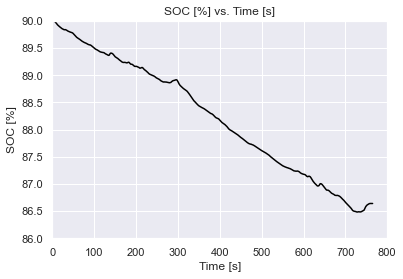

In [ ]:
#Fastsim Stuff

veh = vehicle.Vehicle(22) 
print(veh.Scenario_name)

cyc = cycle.Cycle("hwfet")
sim = simdrive.SimDriveClassic(cyc, veh) 
sim.sim_drive()
secTes  = cyc.cycSecs
socTes = sim.soc*100
plt.plot(cyc.cycSecs, sim.soc*100, color = 'black')

plt.ylim(86, 90)
plt.xlim(0, 800)
plt.xticks(np.arange(0, 800.1, step=100))
plt.yticks(np.arange(86, 90.1, step=.5))
plt.xlabel("Time [s]")
plt.ylabel("SOC [%]")
plt.title('SOC [%] vs. Time [s]')

2016 TESLA Model S60 2WD


Text(0.5, 1.0, 'SOC [%] vs. Time [s]')

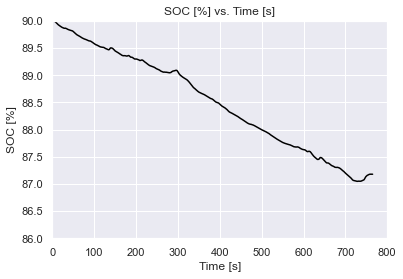

In [ ]:
#Fastsim Stuff
cyc = cycle.Cycle("hwfet")
cyc_jit = cyc.get_numba_cyc()
veh = vehicle.Vehicle(22) 
veh_jit = veh.get_numba_veh()
print(veh.Scenario_name)



veh.vehOverrideKg = 2071
veh.maxMotorKw = 420
veh.wheelRadiusM = 0.4826
veh.wheelBaseM = 4.963
veh.maxEssKwh = 89.3



sim = simdrive.SimDriveClassic(cyc, veh) 
sim.sim_drive()

plt.plot(cyc.cycSecs, sim.soc*100, color = 'black')

plt.ylim(86, 90)
plt.xlim(0, 800)
plt.xticks(np.arange(0, 800.1, step=100))
plt.yticks(np.arange(86, 90.1, step=.5))
plt.xlabel("Time [s]")
plt.ylabel("SOC [%]")
plt.title('SOC [%] vs. Time [s]')

In [ ]:
#UDDS is a standard city drivecycle       1369s, 7.45mi
#hwycol is a standard highway drivecycle  765s, 10.26mi
#US06 is an aggressive drive cycle        596s, 8.01mi

In [ ]:
# Efficiency Map
rear_eff_data = pd.read_excel("Audi_e_Tron_Motors_ResultsForMaps.xlsx", "AKA320-Maps")
x_rear = rear_eff_data["SPEED [rad/s]"]
y_rear = rear_eff_data["TORQUE [Nm]"]
z_rear = rear_eff_data["EFFY [%]"] / 100
interp_eff_rear = LinearNDInterpolator((x_rear, y_rear), z_rear)

In [ ]:
rho = 1.225  # Density of air, kg/m^3
Cd = 0.22  # Coefficient of drag, unitless
A = 2.33  # Frontal area, m^2 
V = 800 # V
Max_Energy_Cap = 93.4 # kWh
Max_Useable_Cap = 83.7 #kWh
Crr = 0.020 # unitlessssssssssssssssssss 🐍
mass = 2071 # kg
g = 9.81 # m/s^2
t_r = 0.4826 # m
regen = 0.90 # https://insideevs.com/reviews/397503/porsche-taycan-regenerative-braking-deep-dive/
pe_loss = 0.98


weight = mass * g
Frr = Crr * weight
Min_useable_Cap = Max_Energy_Cap - Max_Useable_Cap

2.7677934134767033 kWh/HYWCOL Drive Cycle
0.16764345326933391 kWh/km
16.745150151534055 kWh/100km


NameError: name 'secTes' is not defined

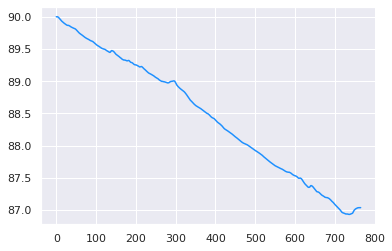

In [ ]:
#hwycol is a standard highway drivecycle  765s, 10.26mi = 16.51 km
cycle = pd.read_csv('hwycol.txt', sep="\t")
cycle_type = 'EPA Drive Cycle: HWYCOL'
MPH_TO_MPS = 0.44704
cycle["Velocity (m/s)"] = cycle["Velocity (mph)"] * MPH_TO_MPS



a = []
b = []
soc_high = []
soc_avg = []
soc_op = []
SOC = .9
SOC1 = .9
SOC2 = .9
SOC3 = .9
pe_input_power1 = 0
prev_power_in_rear = 0
prev_ending_time = 0

for j in range(1):
    for i in range(len(cycle)):
        time = cycle["Time (s)"].iloc[i] + prev_ending_time
        velocity = cycle["Velocity (m/s)"].iloc[i]
        velocity_mph = cycle["Velocity (mph)"].iloc[i]

        if i > 0:
            prev_time = cycle["Time (s)"].iloc[i-1] + prev_ending_time
            prev_velocity = cycle["Velocity (m/s)"].iloc[i-1]

            dt = time - prev_time
            dv = velocity - prev_velocity

            acceleration = dv/dt
        else:
            dt = 1
            acceleration = 0


        #Suspension
        F_drag = 0.5 * rho * velocity**2 * A * Cd
        F_x = mass * acceleration + F_drag + Frr


        #Wheels
        wheel_torque = F_x * t_r
        wheel_angular_speed = velocity / t_r


        #GearBox
        if velocity_mph < 62:
            gear_ratio = 15
        elif velocity_mph >= 62:
            gear_ratio = 8 

        motor_torque = wheel_torque / gear_ratio 
        motor_speed = wheel_angular_speed * gear_ratio

        motor_output_power = motor_torque * motor_speed

        # Motor Efficiency
        rear_efficiency = interp_eff_rear(motor_speed, abs(motor_torque))

        if np.isnan(rear_efficiency):
            rear_efficiency = 1.00

        # motor efficiency losses (W)
        motor_input_power = motor_output_power / rear_efficiency 
        
        if motor_input_power < 0:
            motor_input_power = motor_input_power * regen  

        # power electronics efficiency losses (W)
        pe_input_power = motor_input_power / pe_loss
        pe_input_power1 = pe_input_power1 + pe_input_power

        input_energy = pe_input_power * dt

        # Package Suite high Losses (W)
        pack1 = 760.9

        # Package Suite average Losses (W)
        pack2 = 510 

        # Package Suite optimized Losses (W)
        pack3 = 288.95

        input_energy1 = ( pe_input_power + pack1 ) * dt
        input_energy2 = ( pe_input_power + pack2 ) * dt
        input_energy3 = ( pe_input_power + pack3 ) * dt

        # One kilowatt-hour is equal to 3,600,000 joules
        SOC = SOC - input_energy / (Max_Energy_Cap * 3.6e6)
        if SOC * (Max_Energy_Cap * 3.6e6) <= Min_useable_Cap:
            print("depleted")
        a.append(time)
        b.append(SOC*100)

    prev_ending_time = time

    print(pe_input_power1/3.6e6, "kWh/HYWCOL Drive Cycle")
    print((pe_input_power1/3.6e6)/16.51, "kWh/km")
    print((pe_input_power1/3.6e6)*6.05, "kWh/100km")

# Lets added another figure with the overlaying tesla model and the model you make in FASTSim
# to distinguish from our model vs the output of our model in FASTSim and the Tesla Model S
    # Base model
    plt.plot(a, b, color='dodgerblue', label='Backwards Model')
    plt.plot(secTes, socTes, color = 'Red', label='Fastsim Tesla')
    plt.plot(cyc.cycSecs, sim.soc*100, color = 'Orange', label='Fastsim Taycan')
    plt.xlabel('Time [s]')
    plt.ylabel('SOC [%]')
    plt.title(cycle_type)
    plt.legend()
    plt.grid()
    plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=04b84d8e-8cea-4bd7-b863-0c6c0738da54' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>